In [1]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 KB 1.4 MB/s eta 0:00:001.1 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 KB 5.2 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.14-py3-none-any.whl size=105139 sha256=6eaaa994451f828be6217016aedbda37b01ef6bb68f1e014fdc7e0b8ee95c3e6
  Stored in directory: /home/wizard/.cache/pip/wheels/d7/54/06/8a8f40cb39536605feb9acaacd0237a95eba39e5065e6392f4
Successfully built kaggle


In [2]:
!mkdir -p ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/home/wizard/.kaggle/kaggle.json': No such file or directory


### Import Twitter sentiment dataset

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 88% 71.0M/80.9M [00:00<00:00, 260MB/s]
100% 80.9M/80.9M [00:00<00:00, 251MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "sentiment140.zip"

dataset = "/content/sentiment140.zip"

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [5]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/wizard/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
twitter_data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1')

In [10]:
twitter_data.shape

(1599999, 6)

In [11]:
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [12]:
cols = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [13]:
twitter_data = pd.read_csv('training.1600000.processed.noemoticon.csv',names=cols, encoding='ISO-8859-1')

In [14]:
twitter_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [15]:
twitter_data.shape

(1600000, 6)

In [16]:
twitter_data.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [17]:
# checking the distribution column
twitter_data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

### Convert the target "4" to "1"

In [18]:
twitter_data.replace({'target':{4:1}},inplace=True)

In [19]:
twitter_data.tail()

,target,ids,date,flag,user,text
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,1,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [21]:
twitter_data['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

### 0 ---> Negative Tweets
### 1 ---> Positive Tweets

### Stemming

##### Process of reducing a word to its root word

In [22]:
porter_stemmer_obj = PorterStemmer()

In [23]:
def stemming_data(content):
  stemmed = re.sub('[^a-zA-Z]', ' ', content)
  stemmed = stemmed.lower()
  stemmed = stemmed.split()
  stemmed = [porter_stemmer_obj.stem(word) for word in stemmed if not word in stopwords.words('english')]
  stemmed = ' '.join(stemmed)
  return stemmed

In [24]:
df = pd.concat([twitter_data.head(1000), twitter_data.tail(1000)], ignore_index=True)

In [25]:
df['stemmed_content'] = df['text'].apply(stemming_data)

In [26]:
print(df['stemmed_content'])

0       switchfoot http twitpic com zl awww bummer sho...
1       upset updat facebook text might cri result sch...
2       kenichan dive mani time ball manag save rest g...
3                         whole bodi feel itchi like fire
4                           nationwideclass behav mad see
                              ...                        
1995                           woke school best feel ever
1996    thewdb com cool hear old walt interview http b...
1997                         readi mojo makeov ask detail
1998    happi th birthday boo alll time tupac amaru sh...
1999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 2000, dtype: object


In [27]:
print(df['target'])

0       0
1       0
2       0
3       0
4       0
       ..
1995    1
1996    1
1997    1
1998    1
1999    1
Name: target, Length: 2000, dtype: int64


In [28]:
print(df.columns)

Index(['target', 'ids', 'date', 'flag', 'user', 'text', 'stemmed_content'], dtype='object')


In [29]:
X = df['stemmed_content'].values
Y = df['target'].values

In [30]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [31]:
print(Y)

[0 0 0 ... 1 1 1]


In [32]:
print(Y.size)

2000


###Splitting the data into training data and test data

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,stratify=Y, random_state=2)

In [34]:
print(X.shape, X_train.shape, X_test.shape)

(2000,) (1600,) (400,)


In [35]:
print(X_train)

['syekr myki realli horribl' 'follow peopl mani peopl follow'
 'playradioplay sad unexpect total cri haha' ...
 'ryanmwilson aww stink hug' 'tap rest today prokofiev mozart karg elert'
 'mileycyru well hello miley how life big star dont get sick pap messag back']


###Convert text data to numbers for training the model

In [36]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [37]:
print(X_train)

  (0, 3573)	0.5728120003367105
  (0, 2461)	0.5728120003367105
  (0, 2965)	0.33750789243185575
  (0, 1682)	0.4794384705952574
  (1, 1336)	0.6894112423735854
  (1, 2723)	0.62058863715014
  (1, 2236)	0.3736065876413869
  (2, 2787)	0.506171899899958
  (2, 3098)	0.2996591845523455
  (2, 3864)	0.506171899899958
  (2, 3743)	0.3881614403812397
  (2, 818)	0.3652209543673738
  (2, 1542)	0.3372369186623894
  (3, 2785)	0.2798210144089911
  (3, 347)	0.3243640622820724
  (3, 3547)	0.3957512981483082
  (3, 1819)	0.36005768021519025
  (3, 3880)	0.3957512981483082
  (3, 3786)	0.3957512981483082
  (3, 101)	0.295546644157726
  (3, 1541)	0.36005768021519025
  (4, 1221)	0.32975568045771086
  (4, 2009)	0.32975568045771086
  (4, 3045)	0.22496023204661525
  (4, 4129)	0.2405316653406059
  :	:
  (1597, 1708)	0.47153504037222976
  (1597, 248)	0.45093994148280214
  (1597, 3465)	0.5211573008311354
  (1597, 3094)	0.5501844624006135
  (1598, 3718)	0.22116865254117185
  (1598, 3028)	0.34903273292581055
  (1598, 3594)

In [38]:
print(X_test)

  (0, 260)	0.28141282146906343
  (0, 818)	0.3135269477909566
  (0, 1274)	0.24923590719653121
  (0, 1606)	0.3724113161538941
  (0, 2065)	0.4345274523146595
  (0, 2148)	0.24923590719653121
  (0, 2172)	0.4373438431241407
  (0, 2212)	0.3072381899039952
  (0, 3677)	0.29172138142572107
  (1, 3098)	1.0
  (2, 1426)	0.3050422245929446
  (2, 1557)	0.5226363083603536
  (2, 2172)	0.3270112497359208
  (2, 2885)	0.6155274082765938
  (2, 3098)	0.3846949214706371
  (3, 308)	0.6192693707015463
  (3, 723)	0.3567349146350765
  (3, 1703)	0.336312232698499
  (3, 3707)	0.468441253534917
  (3, 4049)	0.3958566929018653
  (4, 2788)	0.7283873724236672
  (4, 4131)	0.685165553493275
  (5, 512)	0.7734134209119459
  (5, 1670)	0.6339019485324852
  (6, 21)	0.30390116791361477
  :	:
  (397, 155)	0.3615987465909408
  (397, 587)	0.3425211717811796
  (397, 1076)	0.3615987465909408
  (397, 1450)	0.16482873393395336
  (397, 1715)	0.3425211717811796
  (397, 2148)	0.20740551872533847
  (397, 2520)	0.21206785358562386
  (397,

### Training the machine learning model:
#### 1.Logistic Regression

In [39]:
logistic_regression_model = LogisticRegression(max_iter=1000)

In [40]:
logistic_regression_model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

### Model Evaluation using accuracy score

In [41]:
# accuracy score on the trianing data
X_train_prediction = logistic_regression_model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)

In [42]:
print('Accuracy Score of training data: ', training_data_accuracy)

Accuracy Score of training data:  0.93125


In [43]:
# accuracy score on the test data
X_test_prediction = logistic_regression_model.predict(X_test)
test_data_accuracy_logistic = accuracy_score(Y_test, X_test_prediction)

In [44]:
print('Accuracy Score of test data: ', test_data_accuracy_logistic)

Accuracy Score of test data:  0.715


In [45]:
print("Classification Report:\n", classification_report(Y_test, X_test_prediction))

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71       200
           1       0.71      0.71      0.71       200

    accuracy                           0.71       400
   macro avg       0.71      0.71      0.71       400
weighted avg       0.71      0.71      0.71       400



In [46]:
import pickle

In [47]:
filename = 'logistic_trained_model.sav'
pickle.dump(logistic_regression_model, open(filename, 'wb'))

In [48]:
logistic_model_file = pickle.load(open('logistic_trained_model.sav', 'rb'))

In [49]:
X_new = X_test[150]
print(Y_test[150])

prediction = logistic_model_file.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('Negative Tweet')
else:
  print('Positive Tweet')

0
[1]
Positive Tweet


In [50]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,stratify=Y, random_state=2)

### 2.Naive-Bayes Model

In [51]:
bayes_model = MultinomialNB()

In [52]:
bayes_model.fit(X_train, Y_train)

MultinomialNB()

In [53]:
# accuracy score on the trianing data
X_train_prediction = bayes_model.predict(X_train)
training_data_accuracy_bayes = accuracy_score(Y_train, X_train_prediction)

In [54]:
print('Accuracy Score of training data: ', training_data_accuracy_bayes)

Accuracy Score of training data:  0.959375


In [55]:
# accuracy score on the test data
X_test_prediction = bayes_model.predict(X_test)
test_data_accuracy_bayes = accuracy_score(Y_test, X_test_prediction)

In [56]:
print('Accuracy Score of training data: ', test_data_accuracy_bayes)

Accuracy Score of training data:  0.7025


In [57]:
print("Accuracy:", accuracy_score(Y_test, X_test_prediction))
print("Classification Report:\n", classification_report(Y_test, X_test_prediction))

Accuracy: 0.7025
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.72      0.71       200
           1       0.71      0.68      0.70       200

    accuracy                           0.70       400
   macro avg       0.70      0.70      0.70       400
weighted avg       0.70      0.70      0.70       400



### 3.SVM Algorithm

In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,stratify=Y, random_state=2)

In [58]:
svm_model = SVC(kernel='linear')

In [59]:
svm_model.fit(X_train, Y_train)

SVC(kernel='linear')

In [60]:
# accuracy score on the trianing data
X_train_prediction = svm_model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)

In [61]:
print('Accuracy Score of training data: ', training_data_accuracy)

Accuracy Score of training data:  0.96375


In [62]:
# accuracy score on the test data
X_test_prediction = svm_model.predict(X_test)
test_data_accuracy_svm = accuracy_score(Y_test, X_test_prediction)

In [63]:
print('Accuracy Score of training data: ', test_data_accuracy_svm)

Accuracy Score of training data:  0.7025


In [64]:
print("Classification Report:\n", classification_report(Y_test, X_test_prediction))

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70       200
           1       0.70      0.71      0.70       200

    accuracy                           0.70       400
   macro avg       0.70      0.70      0.70       400
weighted avg       0.70      0.70      0.70       400



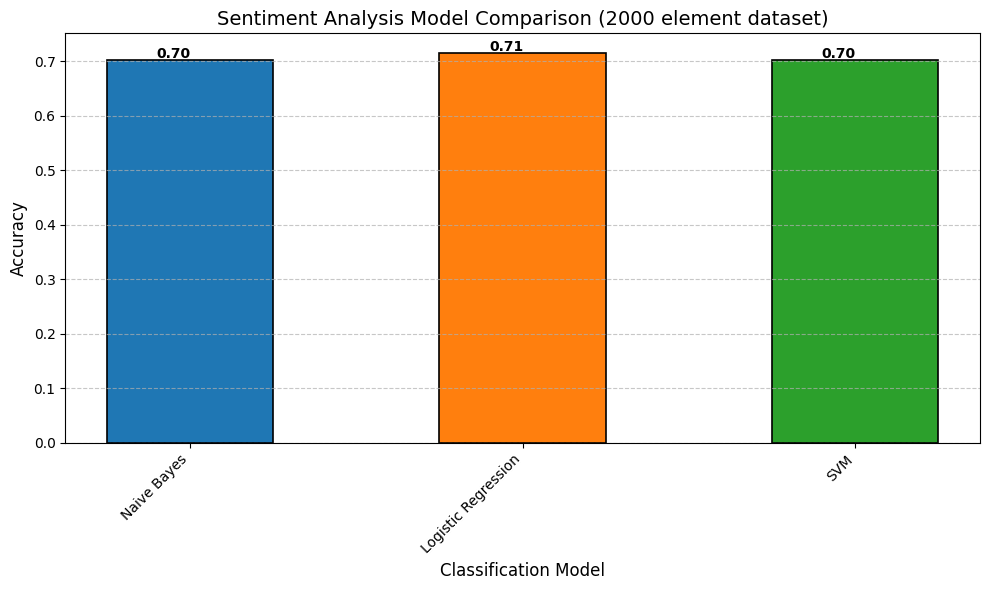

In [65]:
plt.figure(figsize=(10, 6))  # Slightly wider for better spacing

models = ['Naive Bayes', 'Logistic Regression', 'SVM']
accuracy = [test_data_accuracy_bayes, test_data_accuracy_logistic, test_data_accuracy_svm]

bars = plt.bar(models, accuracy, color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black', linewidth=1.2, width=0.5)

# Add value labels on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.05, yval + 0.01, f'{yval:.2f}', va='center', ha='center', fontweight='bold')

plt.xlabel('Classification Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.title('Sentiment Analysis Model Comparison (2000 element dataset)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [66]:
filename = 'bayes_trained_model.sav'
pickle.dump(bayes_model, open(filename, 'wb'))

In [67]:
filename = 'svm_trained_model.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [70]:
import joblib

# `vectorizer` is the CountVectorizer and TfidfVectorizer instance used to train the model
# and `logistic_model` is the trained logistic regression model

# Save the vectorizer and the model
joblib.dump(vectorizer, 'vectorizer.sav')
joblib.dump(logistic_regression_model, 'logistic_model.sav')


['logistic_model.sav']